# Run LFMC Scenario B
This notebook reproduces Scenario 'B' presented in "Live fuel moisture content estimation from MODIS" (Zhu et al., 2010). In this scenario, the sample sites are split into 3 groups. A stratified splitting strategy is used to ensure even splitting across land cover classes. Samples are then grouped based on the sampling site. K-fold cross-validation is used, so each fold uses one group of samples for testing and the other two for training. 

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

from lfmc_model import LfmcTempCnn
from model_utils import reshape_data, normalise, plot_results
from modelling_functions import run_test
from model_parameters import ModelParams

## Directories and Input files
Change these settings as required
- `input_dir`: Directory containing the data extracted from GEE and Globe-LFMC, the outputs from running the `Extract Auxiliary Data.ipynb` and `Extract MODIS Data.ipynb` notebooks.
- `output_dir`: A sub-directory called `model_params['modelName']` (`Scenario_B`) will be created in this directory, where all outputs generated by this notebook will be written. 
- `temp_dir`: A temporary directory where model checkpoints are created. This directory should exist and be empty.
- `modis_csv`: The file containing extracted MODIS data for each sample, created by `Extract MODIS Data.ipynb`
- `aux_csv`: The file containing extracted DEM and other auxiliary data for each sample, created by `Extract Auxiliary Data.ipynb`. This includes the labels and pre-processed site location and sampling date data from Globe-LFMC

In [2]:
input_dir = r'G:\My Drive\LFMC from MODIS\TrainingData'
output_dir = r'G:\My Drive\LFMC from MODIS\Models'
temp_dir = r'C:\Temp\LFMC'
modis_csv = os.path.join(input_dir, 'modis.csv')
aux_csv = os.path.join(input_dir, 'sample.csv')

## Set up model parameters
Set up and customise the model parameters. Leave all parameters as set here to run Scenario B. To find out more about any parameter, run `model_params.help('<parameter>')` after running this cell to create the ModelParams object.

In [3]:
# Customize model parameters
model_params = ModelParams(conv_layers=3, fc_layers=2)

model_params['modelName'] = 'Scenario_B'
model_params['description'] = 'Estimate LFMC for Globel-LFMC samples using corss-validation with samples split by site into 3 groups.'
model_params['modisFilename'] = modis_csv
model_params['auxFilename'] = aux_csv
model_params['splitMethod'] = 'bySite'
model_params['splitFolds'] = 3

model_params['tempDir'] = temp_dir
model_params['modelDir'] = os.path.join(output_dir, model_params['modelName'])
if not os.path.exists(model_params['modelDir']):
    os.makedirs(model_params['modelDir'])

model_params['conv'][0]['poolSize'] = 2
model_params['conv'][1]['poolSize'] = 3
model_params['conv'][2]['poolSize'] = 4

model_params

{'modelName': 'Scenario_B',
 'description': 'Estimate LFMC for Globel-LFMC samples using corss-validation with samples split by site into 3 groups.',
 'modelDir': 'G:\\My Drive\\LFMC from MODIS\\Models\\Scenario_B',
 'tempDir': 'C:\\Temp\\LFMC',
 'randomSeed': 1234,
 'modelRuns': 1,
 'resplit': False,
 'seedList': [],
 'modisFilename': 'G:\\My Drive\\LFMC from MODIS\\TrainingData\\modis.csv',
 'modisChannels': 7,
 'modisNormalise': {'method': 'minMax', 'percentiles': 2},
 'modisDays': 365,
 'auxFilename': 'G:\\My Drive\\LFMC from MODIS\\TrainingData\\sample.csv',
 'auxColumns': 9,
 'auxAugment': False,
 'targetColumn': 'LFMC value',
 'splitMethod': 'bySite',
 'splitSizes': (0.33, 0.086),
 'siteColumn': 'Site',
 'splitStratify': 'Land Cover',
 'splitYear': 2013,
 'yearColumn': 'Sampling year',
 'splitFolds': 3,
 'batchNormalise': True,
 'dropoutRate': 0.5,
 'regulariser': 'keras.regularizers.l2(1.e-6)',
 'validationSet': False,
 'earlyStopping': False,
 'epochs': 100,
 'batchSize': 32,


## Prepare the data

In [4]:
modis_df = pd.read_csv(modis_csv)
modis_start = model_params['modisDays'] * model_params['modisChannels']
x_modis = reshape_data(np.array(modis_df.iloc[:, -modis_start:]), model_params['modisChannels'])
x_modis = normalise(x_modis, **model_params['modisNormalise'])
print(f'Modis shape: {x_modis.shape}')

aux_df = pd.read_csv(aux_csv, index_col=0)
y = aux_df[model_params['targetColumn']]
aux_start = len(aux_df.columns) - model_params['auxColumns']
x_aux = np.array(aux_df.iloc[:, aux_start:])
if model_params['auxAugment']:
    x_aux = np.concatenate([x_aux, x_modis[:, -1, :]], axis=1)
print(f'Auxiliary shape: {x_aux.shape}')

Modis shape: (65663, 365, 7)
Auxiliary shape: (65663, 9)


## Build and run the model
Builds and trains the LFMC model. After training the model, several derived models are created and evaluated. The full list of models is:
- `base` - The fully trained model
- `best` - A model using the checkpoint with the best training loss
- `merge10` - A model created by merging the last 10 checkpoints. The checkpoints are merged by averaging the corresponding weights from each model.
- `ensemble10` - An ensembled model of the last 10 checkpoints. This model averages the predictions made by each model in the ensemble to make the final prediction.
- `merge_best10` - Similar to the merge10 model, but uses the 10 checkpoints with the lowest training/validation losses.

All models, predictions, evaluation statistics, and plots of test results are saved to `model_dir`. Predictions and evaluation statistics are also returned as attributes of the `model` object. 

In [5]:
with open(os.path.join(model_params['modelDir'], 'model_params.json'), 'w') as f:
    model_params.save(f)
model = run_test(model_params, aux_df, {'modis': x_modis, 'aux': x_aux}, y)

Split by Site, stratify by Land Cover
Training results: minLoss: 587.8777465820312, runTime: 935.15
Training results: minLoss: 576.6404418945312, runTime: 906.84
Training results: minLoss: 588.6904296875, runTime: 945.26


## Display the results
Display a summary of the statistics for each model
- Bias: The difference between the mean prediction and the mean label
- RMSE: The root mean squared error of the predictions
- ubRMSE (Unbiased RMSE): The RMSE obtained if each prediction is adjusted by the Bias
- R: The correlation coefficient
- R2 (R-squared): The percent of variance explained
- runTime: The time (in seconds) to predict all test samples

In [6]:
model.all_stats

,Bias,R,R2,RMSE,ubRMSE
base,-3.47,0.65,0.43,28.13,27.91
best,-2.47,0.63,0.40,29.03,28.93
merge_best10,-3.81,0.66,0.44,28.04,27.78
merge10,-4.19,0.66,0.44,28.05,27.74
ensemble10,-4.09,0.67,0.44,27.86,27.56


## Plot the Results
Create a scatter plot using the `merge10` results that compares the estimated LFMC to the measured LFMC of the test samples.

To plot any of the other models, change the value of `plot_model` to the required model. 

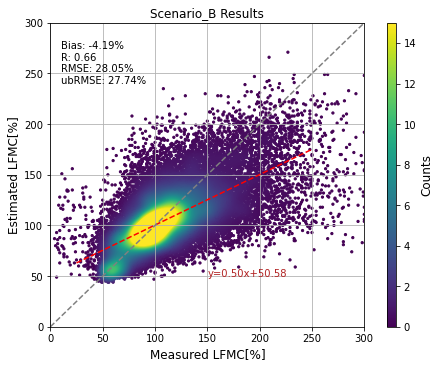

In [10]:
plot_model = 'merge10'
vmax = 15
fig = plt.figure(constrained_layout=True, figsize=(6, 5))
gspec = fig.add_gridspec(ncols=1, nrows=1)
plot = fig.add_subplot(gspec[0, 0])
plot_results(model_params['modelName'], model.all_results.y, model.all_results[plot_model], model.all_stats.loc[plot_model], ax=plot, vmax=vmax)
cbar = fig.colorbar(cm.ScalarMappable(norm = Normalize(vmin=0, vmax=vmax)), ax=fig.axes[0], aspect=40)
_ = cbar.ax.set_ylabel('Counts', fontsize=12)